# **ResNet Implementation and Comparison**

*Objective: Implement a ResNet model and evaluate its performance against other CNN architectures.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import time


2024-10-01 17:07:26.892580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 17:07:27.562563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## **Load Dataset and Data Preprocessing**

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {x_test.shape}, Testing labels shape: {y_test.shape}")

# normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# one-hot
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# split data
x_train_aug, x_val, y_train_aug, y_val = train_test_split(x_train, y_train, test_size=0.2)


Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3), Testing labels shape: (10000, 1)
y_train shape: (50000, 10)
y_test shape: (10000, 10)


In [3]:
# data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

batch_size = 64

train_generator = train_datagen.flow(
    x_train_aug, y_train_aug,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    x_val, y_val,
    batch_size=batch_size,
    shuffle=False
)


In [4]:
def visualize(generator, num_images=9):
    augmented_images, _ = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Uncomment to visualize
#visualize(train_generator)


## **Network Architecture**

In [5]:
def basic(inputs, filters, stride=1):
    # residual blocks for resnets
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer='he_normal')(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# resnet models
def ResNet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # blocks per stage
    num_blocks = [2, 2, 2, 2]
    filters = 64

    for i in range(4):
        for j in range(num_blocks[i]):
            stride = 1
            if i != 0 and j == 0:
                stride = 2
            x = basic(x, filters, stride)
        filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def ResNet34(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # adjust layers 
    num_blocks = [3, 4, 6, 3]
    filters = 64

    for i in range(4):
        for j in range(num_blocks[i]):
            stride = 1
            if i != 0 and j == 0:
                stride = 2
            x = basic(x, filters, stride)
        filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def simple_cnn(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [6]:
# callbacks
def get_callbacks(model_name):
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    checkpoint = callbacks.ModelCheckpoint(
        filepath=f'{model_name}.keras',
        monitor='val_loss',
        save_best_only=True
    )

    lr_reduce = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        verbose=1
    )
    return [early_stop, checkpoint, lr_reduce]

# compile -> train
def compile_and_train(model, model_name, train_gen, val_gen, epochs=100):
    model.compile(
        optimizer=optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    cb = get_callbacks(model_name)

    start_time = time.time()
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=cb,
        steps_per_epoch=len(train_gen),
        validation_steps=len(val_gen),
        verbose=1
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time for {model_name}: {training_time:.2f} seconds")

    return history, training_time


In [7]:
# initialize models
resnet18 = ResNet18(input_shape=(32, 32, 3), num_classes=10)
resnet34 = ResNet34(input_shape=(32, 32, 3), num_classes=10)
cnn_model = simple_cnn(input_shape=(32, 32, 3), num_classes=10)

# ResNet-18
with tf.device('/GPU:0'):
    history_resnet18, time_resnet18 = compile_and_train(
        resnet18, 'ResNet18',
        train_generator, val_generator,
        epochs=10
    )

# ResNet-34
with tf.device('/GPU:0'):
    history_resnet34, time_resnet34 = compile_and_train(
        resnet34, 'ResNet34',
        train_generator, val_generator,
        epochs=10
    )

# CNN
with tf.device('/GPU:0'):
    history_cnn, time_cnn = compile_and_train(
        cnn_model, 'SimpleCNN',
        train_generator, val_generator,
        epochs=10
    )


2024-10-01 17:07:30.311124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9056 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:42:00.0, compute capability: 7.5


Epoch 1/10


2024-10-01 17:07:31.622524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-10-01 17:07:35.263707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-10-01 17:07:35.790200: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f391009c130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-01 17:07:35.790263: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-10-01 17:07:35.797462: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 17:07:35.

625/625 [==============================] - ETA: 0s - loss: 1.5763 - accuracy: 0.4293

2024-10-01 17:08:04.181664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 35s 36ms/step - loss: 1.5763 - accuracy: 0.4293 - val_loss: 1.5468 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 22s 36ms/step - loss: 1.1666 - accuracy: 0.5835 - val_loss: 1.0421 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 22s 35ms/step - loss: 0.9647 - accuracy: 0.6601 - val_loss: 1.3826 - val_accuracy: 0.5843 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 21s 34ms/step - loss: 0.8406 - accuracy: 0.7061 - val_loss: 0.8088 - val_accuracy: 0.7315 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 22s 35ms/step - loss: 0.7588 - accuracy: 0.7371 - val_loss: 1.1552 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 22s 35ms/step - loss: 0.6808 - accuracy: 0.7610 - val_loss: 0.9156 - val_accuracy: 0.7348 - lr: 0.0010
Epoch 7/10
625/625 [==============================] - 23s 36ms/step -

2024-10-01 17:11:25.314407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - ETA: 0s - loss: 1.6809 - accuracy: 0.3908

2024-10-01 17:12:16.986712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 55s 61ms/step - loss: 1.6809 - accuracy: 0.3908 - val_loss: 2.2083 - val_accuracy: 0.3937 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 38s 61ms/step - loss: 1.2746 - accuracy: 0.5422 - val_loss: 1.9243 - val_accuracy: 0.4511 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 39s 62ms/step - loss: 1.0413 - accuracy: 0.6344 - val_loss: 1.1296 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 37s 59ms/step - loss: 0.9063 - accuracy: 0.6853 - val_loss: 1.1587 - val_accuracy: 0.6413 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 38s 60ms/step - loss: 0.7930 - accuracy: 0.7244 - val_loss: 1.2255 - val_accuracy: 0.6672 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 38s 61ms/step - loss: 0.7280 - accuracy: 0.7472 - val_loss: 1.1634 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 7/10
625/625 [==============================] - 38s 61ms/step -

2024-10-01 17:18:02.725596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-10-01 17:18:03.775225: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - ETA: 0s - loss: 1.8155 - accuracy: 0.3687

2024-10-01 17:18:23.752668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 22s 30ms/step - loss: 1.8155 - accuracy: 0.3687 - val_loss: 1.5246 - val_accuracy: 0.4432 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 18s 29ms/step - loss: 1.4479 - accuracy: 0.4784 - val_loss: 1.3734 - val_accuracy: 0.5187 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 18s 28ms/step - loss: 1.2863 - accuracy: 0.5397 - val_loss: 1.3085 - val_accuracy: 0.5492 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 17s 28ms/step - loss: 1.1870 - accuracy: 0.5781 - val_loss: 0.9834 - val_accuracy: 0.6528 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 18s 29ms/step - loss: 1.1187 - accuracy: 0.5997 - val_loss: 1.0460 - val_accuracy: 0.6310 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 18s 29ms/step - loss: 1.0669 - accuracy: 0.6208 - val_loss: 1.4139 - val_accuracy: 0.5451 - lr: 0.0010
Epoch 7/10
625/625 [==============================] - 18s 28ms/step -

In [8]:
def fine_tune_model(model, model_name, train_gen, val_gen, fine_tune_at, epochs=50):
    # unfreeze layers to update weights
    for layer in model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in model.layers[fine_tune_at:]:
        layer.trainable = True

    # compile with lower learning rate 
    model.compile(
        optimizer=optimizers.Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    cb = get_callbacks(model_name)

    # time it takes
    start_time = time.time()
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=cb,
        steps_per_epoch=len(train_gen),
        validation_steps=len(val_gen),
        verbose=1
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Fine-tuning time for {model_name}: {training_time:.2f} seconds")

    return history, training_time


In [9]:
# Fine-tune ResNet-18
history_ft_resnet18, time_ft_resnet18 = fine_tune_model(
    resnet18, 'FineTuned_ResNet18',
    train_generator, val_generator,
    fine_tune_at= -10,  # fine the last 10 layers
    epochs=50 #10
)

# Fine-tune ResNet-34
history_ft_resnet34, time_ft_resnet34 = fine_tune_model(
    resnet34, 'FineTuned_ResNet34',
    train_generator, val_generator,
    fine_tune_at= -10,  # fine tune last 10 layers
    epochs=50
)


Epoch 1/50


2024-10-01 17:21:04.630035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


624/625 [============================>.] - ETA: 0s - loss: 0.5102 - accuracy: 0.8228

2024-10-01 17:21:23.543877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 21s 30ms/step - loss: 0.5099 - accuracy: 0.8229 - val_loss: 0.5178 - val_accuracy: 0.8334 - lr: 1.0000e-05
Epoch 2/50
625/625 [==============================] - 19s 30ms/step - loss: 0.4740 - accuracy: 0.8365 - val_loss: 0.4982 - val_accuracy: 0.8372 - lr: 1.0000e-05
Epoch 3/50
625/625 [==============================] - 19s 31ms/step - loss: 0.4750 - accuracy: 0.8369 - val_loss: 0.4940 - val_accuracy: 0.8393 - lr: 1.0000e-05
Epoch 4/50
625/625 [==============================] - 19s 31ms/step - loss: 0.4687 - accuracy: 0.8381 - val_loss: 0.4897 - val_accuracy: 0.8400 - lr: 1.0000e-05
Epoch 5/50
625/625 [==============================] - 18s 30ms/step - loss: 0.4681 - accuracy: 0.8383 - val_loss: 0.4860 - val_accuracy: 0.8405 - lr: 1.0000e-05
Epoch 6/50
625/625 [==============================] - 19s 31ms/step - loss: 0.4665 - accuracy: 0.8377 - val_loss: 0.4819 - val_accuracy: 0.8419 - lr: 1.0000e-05
Epoch 7/50
625/625 [=========================

2024-10-01 17:37:06.004673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - ETA: 0s - loss: 0.5235 - accuracy: 0.8188

2024-10-01 17:37:26.495218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 24s 34ms/step - loss: 0.5235 - accuracy: 0.8188 - val_loss: 0.4775 - val_accuracy: 0.8386 - lr: 1.0000e-05
Epoch 2/50
625/625 [==============================] - 21s 33ms/step - loss: 0.4959 - accuracy: 0.8293 - val_loss: 0.4668 - val_accuracy: 0.8430 - lr: 1.0000e-05
Epoch 3/50
625/625 [==============================] - 20s 32ms/step - loss: 0.4876 - accuracy: 0.8335 - val_loss: 0.4680 - val_accuracy: 0.8429 - lr: 1.0000e-05
Epoch 4/50
625/625 [==============================] - 21s 33ms/step - loss: 0.4862 - accuracy: 0.8326 - val_loss: 0.4668 - val_accuracy: 0.8436 - lr: 1.0000e-05
Epoch 5/50
625/625 [==============================] - 21s 33ms/step - loss: 0.4824 - accuracy: 0.8336 - val_loss: 0.4660 - val_accuracy: 0.8438 - lr: 1.0000e-05
Epoch 6/50
625/625 [==============================] - 20s 33ms/step - loss: 0.4785 - accuracy: 0.8332 - val_loss: 0.4627 - val_accuracy: 0.8455 - lr: 1.0000e-05
Epoch 7/50
625/625 [=========================

In [10]:
def evaluate_model(model, model_name, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"{model_name} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return loss, accuracy

# Evaluate ResNet-18, ResNet-34, Fine-Tuned ResNet-18, Fine-Tuned ResNet-34, Simple CNN
loss_resnet18, acc_resnet18 = evaluate_model(resnet18, 'ResNet18', x_test, y_test)
loss_resnet34, acc_resnet34 = evaluate_model(resnet34, 'ResNet34', x_test, y_test)
loss_ft_resnet18, acc_ft_resnet18 = evaluate_model(resnet18, 'FineTuned_ResNet18', x_test, y_test)
loss_ft_resnet34, acc_ft_resnet34 = evaluate_model(resnet34, 'FineTuned_ResNet34', x_test, y_test)
loss_cnn, acc_cnn = evaluate_model(cnn_model, 'SimpleCNN', x_test, y_test)

313/313 [==============================] - 3s 7ms/step - loss: 0.4292 - accuracy: 0.8610
ResNet18 - Test Loss: 0.4292, Test Accuracy: 0.8610
313/313 [==============================] - 4s 12ms/step - loss: 0.4441 - accuracy: 0.8492
ResNet34 - Test Loss: 0.4441, Test Accuracy: 0.8492
313/313 [==============================] - 2s 7ms/step - loss: 0.4292 - accuracy: 0.8610
FineTuned_ResNet18 - Test Loss: 0.4292, Test Accuracy: 0.8610
313/313 [==============================] - 4s 12ms/step - loss: 0.4441 - accuracy: 0.8492
FineTuned_ResNet34 - Test Loss: 0.4441, Test Accuracy: 0.8492
313/313 [==============================] - 1s 3ms/step - loss: 1.0363 - accuracy: 0.6433
SimpleCNN - Test Loss: 1.0363, Test Accuracy: 0.6433


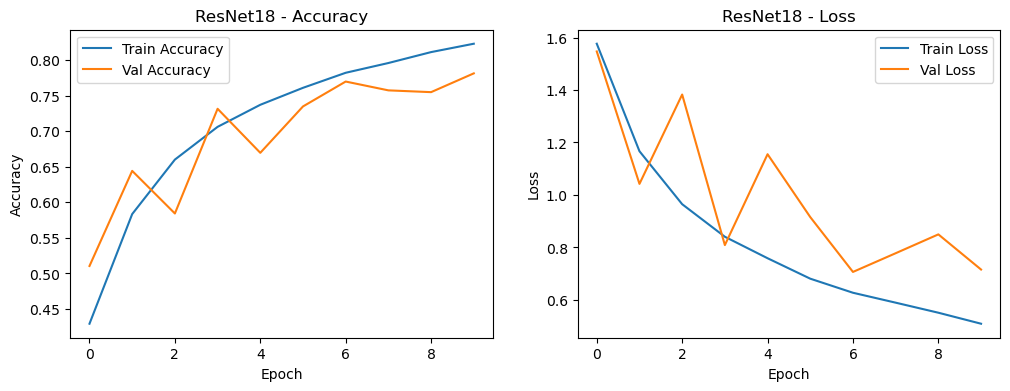

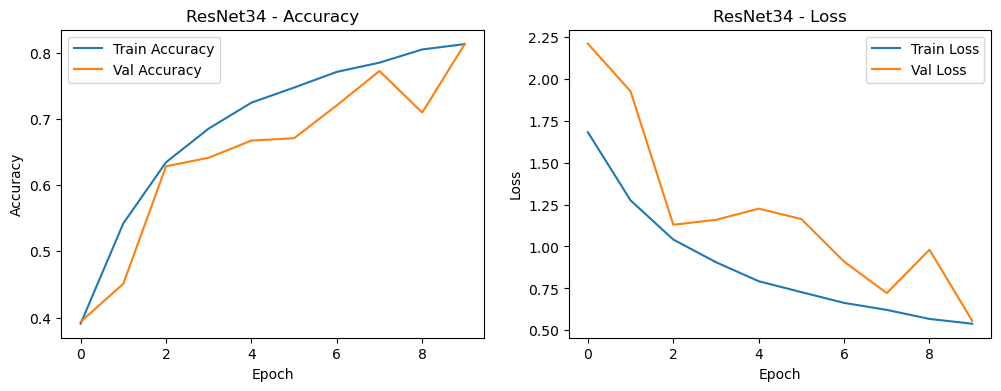

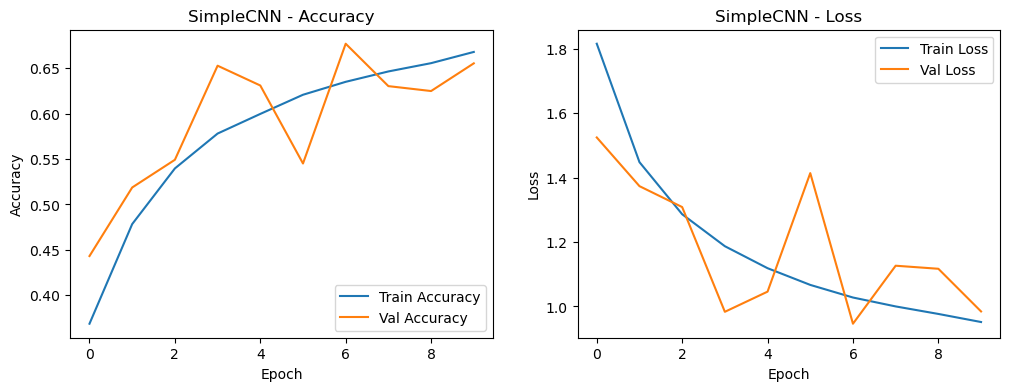

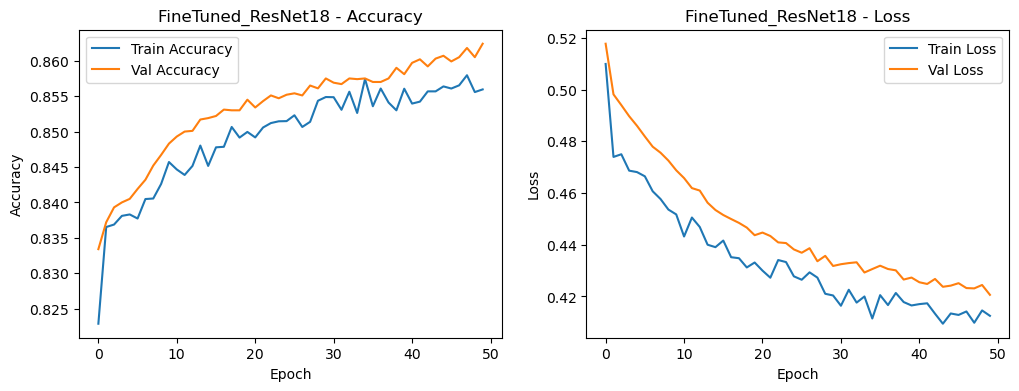

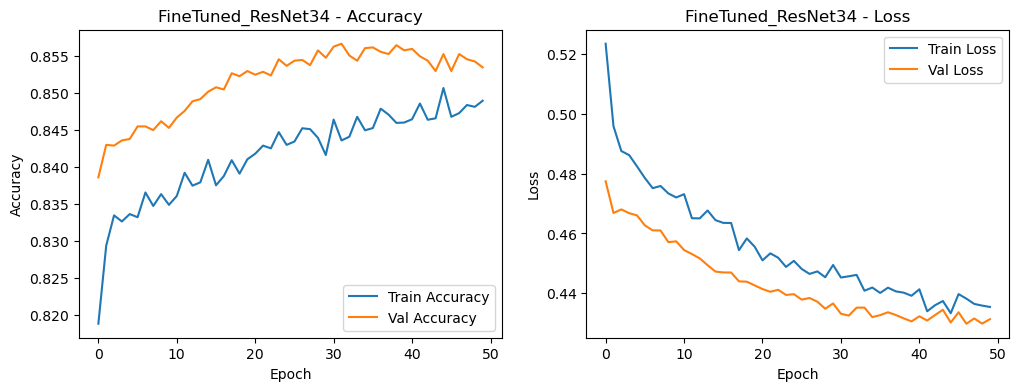

In [11]:
# polt histories
def plot_history(histories, titles):
    for history, title in zip(histories, titles):
        # Accuracy
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f'{title} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{title} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

# Plot histories
plot_history(
    [history_resnet18, history_resnet34, history_cnn, history_ft_resnet18, history_ft_resnet34],
    ['ResNet18', 'ResNet34', 'SimpleCNN', 'FineTuned_ResNet18', 'FineTuned_ResNet34']
)


In [12]:
import pandas as pd
# final results
data = {
    'Model': [
        'ResNet18',
        'FineTuned ResNet18',
        'ResNet34',
        'FineTuned ResNet34',
        'SimpleCNN'
    ],
    'Test Loss': [
        loss_resnet18,
        loss_ft_resnet18,
        loss_resnet34,
        loss_ft_resnet34,
        loss_cnn
    ],
    'Test Accuracy': [
        acc_resnet18,
        acc_ft_resnet18,
        acc_resnet34,
        acc_ft_resnet34,
        acc_cnn
    ],
    'Training Time (s)': [
        time_resnet18,
        time_ft_resnet18,
        time_resnet34,
        time_ft_resnet34,
        time_cnn
    ]
}

df = pd.DataFrame(data)
print(df)


                Model  Test Loss  Test Accuracy  Training Time (s)
0            ResNet18   0.429178         0.8610         233.684498
1  FineTuned ResNet18   0.429178         0.8610         961.355592
2            ResNet34   0.444086         0.8492         397.405741
3  FineTuned ResNet34   0.444086         0.8492        1035.593718
4           SimpleCNN   1.036272         0.6433         181.864405


We can see some improved accuracy when comparing to the simpleCNN, though training time is the trade off. We can see that the Resnets all had above 80% accuracy while the simple cnn was below. Based from the graphs we can also observe that fine-tuning has benefits as it led to more improvements in accuracy. Additionally, the resnet models seem to converge faster than the simple CNN. This could mean that the resent models provide a more clearer path for gradient descent. 